In [1]:
import gc
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import numpy as np
from utils.tsp_solver import k_opt
from utils.visualize import visualize_paths, visualize_subtours
from concurrent.futures import ProcessPoolExecutor
import time
import os

In [2]:
# Chose number of robots
k = 100
# Chose the number of targets in an axis
n = 500
# Chose the length of distance of each side of the square arena
d = 3.
# Choose the redundancy parameter (have each target be visited by exactly that many robots)
rp = min(3, k)
# Fuel Capacity Parameters
max_fuel_cost_to_node = d * np.sqrt(2)  # √8 is the max possible distance between our nodes (-1, -1) and (1, 1)
L_min = max_fuel_cost_to_node * 2  # √8 is the max possible distance between our nodes (-1, -1) and (1, 1)
L = L_min * 1.5  # Fuel capacity (1 unit of fuel = 1 unit of distance)

precision_float_type = np.float16
enable_tsp_optimization = False

## 1. Create map and get node indices


targets.shape=(250000, 2)
depots.shape=(1, 2)


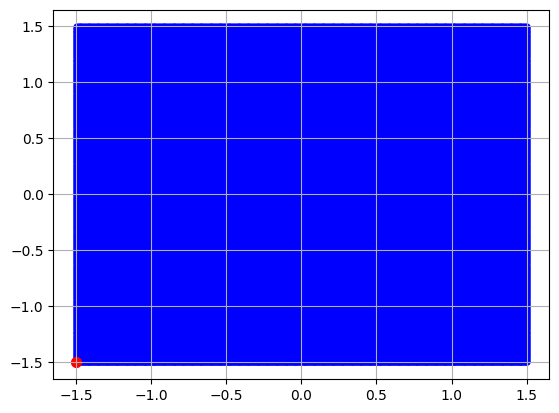

In [3]:
# 1. Create map and get node indices
def construct_map(n, d):
    # nodes = targets + depots
    ulb = (d/2.)  # Upper/Lower bound
    # Create a uniform (n*n, 2) numpy target grid for MAXIMUM SPEED
    xy = np.linspace(-ulb, ulb, n, dtype=precision_float_type)
    xtargets, ytargets = np.meshgrid(xy, xy)
    targets = np.concatenate((xtargets.reshape((n*n, 1)), ytargets.reshape((n*n, 1))), axis=1)
    target_indices = list(range(len(targets)))
    print(f"{targets.shape=}")

    # Specify depots
    # One depot node in the corner
    depots = np.array([
        [-ulb, -ulb],
    ])
    print(f"{depots.shape=}")
    depot_indices = list(range(len(targets), len(targets) + len(depots)))

    nodes = np.concatenate((targets, depots))
    # print(f"{nodes.shape=}")
    node_indices = list(range(len(targets) + len(depots)))

    # Graphical sanity check
    plt.figure()
    plt.scatter(targets[:, 0], targets[:, 1], c='blue', s=10)
    plt.scatter(depots[:, 0], depots[:, 1], c='red', s=50)
    plt.grid()
    plt.show()

    return nodes, node_indices, target_indices, depot_indices


nodes, node_indices, target_indices, depot_indices = construct_map(n, d)

## 2. Calculate cost between each node


In [4]:
# 2. Calculate cost between each node
from tqdm import tqdm
from scipy.spatial import distance
# import gc

start = time.time()
max_n = 200
cost = np.zeros((nodes.shape[0], nodes.shape[0]), dtype=precision_float_type)
if n <= max_n:
    cost = distance.cdist(nodes, nodes, 'euclidean').astype(precision_float_type)
else:
    num_of_broken_indices = int(2 + ((n ** 4) / (max_n ** 4)))
    broken_indices = np.linspace(0, nodes.shape[0], num_of_broken_indices, dtype=int)
    # print(f"{broken_indices=}")
    for i in tqdm(range(len(broken_indices)-1)):

        idx1 = broken_indices[i]
        idx2 = broken_indices[i+1]
        # print(f"{idx1=} {idx2=}")
        # print(f"{nodes[idx1:idx2].shape=} {nodes.shape=}")
        newcost = np.zeros((idx2-idx1, nodes.shape[0]))
        distance.cdist(nodes[idx1:idx2], nodes, 'euclidean', out=newcost)
        cost[idx1:idx2, :] = newcost.astype(precision_float_type)
        del newcost
        gc.collect()

print(f"took {time.time() - start} seconds")
print(f"{cost.shape=}")


 18%|█▊        | 7/40 [00:56<04:26,  8.07s/it]


KeyboardInterrupt: 

## 3. Solve for given parameters

In [ ]:
# Step 1: sort the node indices for creating subtours
start = time.time()
heading_values = []
for n_i in target_indices:
    v1 = nodes[n_i]
    v2 = nodes[depot_indices[0]]
    heading = np.arctan2(*(v1 - v2)) % (2 * np.pi)
    heading_values.append(heading)
heading_values = np.array(heading_values)
# print(f"{heading_values.shape=}")
nodes_costs = cost[:depot_indices[0], depot_indices[0]]
# print(f"{nodes_costs.shape=}")
sorted_indices = np.lexsort((nodes_costs, heading_values))
# for i, ti in enumerate(sorted_indices):
#     print(f"{i=} {ti=} {heading_values[ti]=} {nodes_costs[ti]=}")
print(f"Step 1 took {time.time() - start} seconds.")


In [ ]:
# Step 2: Divide nodes to subtours s.t. cost <= L
def divideArrayByP(array, maxp, countf, low=None, high=None, force_p_equals=False):
    if low is None:
        low = min(array)
    if high is None:
        high = sum(array)

    # condition = True
    maxSum = low
    maxSum_max = high
    maxSum_min = low
    err_thresh = 0.01
    pc_prev = None
    same_pc_counter = 0
    best_p, best_p_a, best_p_c = np.inf, None, [np.inf]
    while True:
        # print(f"{maxSum_max=} {delta=} {maxSum=}")
        p, p_a, p_c = countf(array, maxSum)
        if p > maxp:
            maxSum_min = maxSum
        elif p < maxp:
            maxSum_max = min(maxSum, maxSum_max)
        else:
            maxSum_max = min(maxSum, maxSum_max)

        if force_p_equals:
            if maxp <= p <= best_p:
                best_p = p
                best_p_a = p_a
                best_p_c = p_c
        else:
            if p <= best_p:
                best_p = p
                best_p_a = p_a
                best_p_c = p_c

        # print(f"{p=} {max(p_c)=} {maxSum=} {maxSum_min=} {maxSum_max=} {maxSum_max - maxSum_min=} {best_p=}")
        # print(f"{p=} {p_a=} {p_c=}")
        # time.sleep(0.5)

        if p_c == pc_prev:
            same_pc_counter += 1
        else:
            same_pc_counter = 0

        pc_prev = p_c
        if (best_p <= maxp or same_pc_counter > 2) and maxSum_max - maxSum_min < err_thresh:
            return best_p_a, best_p_c, maxSum

        if p > maxp and maxSum <= high:
            delta = maxSum_max - maxSum
            maxSum = maxSum + delta / 2.
        else:
            delta = maxSum - maxSum_min
            maxSum = maxSum - delta / 2.


start = time.time()
# https://takeuforward.org/arrays/split-array-largest-sum/
def countSubtourPartitions(a, maxSum):
    # n = len(a)  # size of array
    partitions = 1
    partitions_array = [[depot_indices[0], depot_indices[0]]]
    partitions_cost = []
    node_addition_cost = 0
    subarraySum = 0
    for i in sorted_indices:
        node_addition_index = 1
        node_addition_cost = np.inf
        subarraySum = 0
        for j, n_j in enumerate(partitions_array[partitions - 1][:-1]):
            n_k = partitions_array[partitions - 1][j + 1]
            edge_cost = cost[n_j, n_k]
            subarraySum += edge_cost
            new_edge_cost = cost[n_j, i] + cost[i, n_k]
            if new_edge_cost - edge_cost < node_addition_cost:
                node_addition_cost = new_edge_cost - edge_cost
                node_addition_index = j + 1

        if subarraySum + node_addition_cost >= maxSum:
            # if not, insert element to next subarray
            partitions_cost.append(subarraySum)
            partitions += 1
            node_addition_index = 1
            partitions_array.append([depot_indices[0], depot_indices[0]])
        partitions_array[partitions - 1].insert(node_addition_index, i)
        # print(f"{partitions_array[partitions-1]}")

    if len(partitions_array) != len(partitions_cost):
        partitions_cost.append(subarraySum + node_addition_cost)
    return partitions, partitions_array, partitions_cost

tsp_subtours, tsp_costs, maxSum = divideArrayByP(nodes_costs, k, countSubtourPartitions, low=L_min, high=L)
print(f"Step 2: Found {len(tsp_subtours)} subtours.")
# print(f"{L=}")
# print(f"{len(distributed_nodes_indices)=} {maxSum=}")
# print(f"{distributed_nodes_indices=}")
# print(f"{tsp_upper_bound=}")
# visualize_subtours(distributed_nodes_indices, nodes, node_indices, target_indices, depot_indices, cost, mode="faster")
print(f"Step 2 took {time.time() - start} seconds.")


In [ ]:
# Step 3: Further optimize the subtours by running tsp on them
start = time.time()
if enable_tsp_optimization:
    tsp_subtours_prev, tsp_costs_prev = tsp_subtours, tsp_costs
    tsp_subtours = []
    tsp_costs = []
    with ProcessPoolExecutor(max_workers=os.cpu_count() - 1) as executor:
        futures = []
        for heur_subtour in tsp_subtours_prev:
            futures.append(executor.submit(k_opt, *[heur_subtour, cost, 2]))
    
        uncompleted_jobs = list(range(len(futures)))
        while len(uncompleted_jobs) != 0:
            new_uncompleted_jobs = uncompleted_jobs
            for future_i in uncompleted_jobs:
                if futures[future_i].done():
                    best_subtour, c = futures[future_i].result()
                    print(
                        f"\t[subtour {future_i + 1}/{len(futures)}] took {time.time() - start:.3f} seconds and improved {(1 - c / tsp_costs_prev[future_i]) * 100:.3f}%.")
                    tsp_subtours.append(best_subtour)
                    tsp_costs.append(c)
                    new_uncompleted_jobs.remove(future_i)
                else:
                    time.sleep(0.1)
            uncompleted_jobs = new_uncompleted_jobs

tsp_indices = np.array(tsp_costs).argsort().tolist()
# visualize_subtours(tsp_subtours, nodes, node_indices, target_indices, depot_indices, cost, mode="faster")
print(f"Step 3 took {time.time() - start} seconds.")


In [ ]:
# Step 4: Ensure rp
start = time.time()
num_of_subtours = len(tsp_subtours)
for i in range(num_of_subtours, num_of_subtours * rp):
    tsp_subtours.append(tsp_subtours[i % num_of_subtours])
    tsp_costs.append(tsp_costs[i % num_of_subtours])
    tsp_indices.append(i)
print(f"Step 4 took {time.time() - start} seconds.")


In [ ]:
# Step 5: Divide subtours between robots
start = time.time()

def countRobotPartitions(a, maxSum):
    # n = len(a)  # size of array
    partitions = 1
    subarraySum = 0
    partitions_array = [[]]
    partitions_cost = []
    for i in tsp_indices:
        if subarraySum + a[i] <= maxSum:
            # insert element to current subarray
            subarraySum += a[i]
        else:
            # if not, insert element to next subarray
            partitions_cost.append(subarraySum)
            partitions += 1
            subarraySum = a[i]
            partitions_array.append([])
        partitions_array[partitions - 1].append(tsp_subtours[i])

    if len(partitions_array) != len(partitions_cost):
        partitions_cost.append(subarraySum)

    return partitions, partitions_array, partitions_cost

optimized_node_paths, optimized_node_path_costs, maxSum = divideArrayByP(tsp_costs, k, countRobotPartitions, force_p_equals=True)
# for i, optimized_node_path in enumerate(optimized_node_paths):
#     print(f"[{i}] {len(optimized_node_path)=} cost=({optimized_node_path_costs[i]})")
print(f"{sum(optimized_node_path_costs)=} {max(optimized_node_path_costs)=}")
optimized_world_paths = []
for ki in range(k):
    robot_world_path = []
    for i, subtour in enumerate(optimized_node_paths[ki]):
        robot_world_path.append(nodes[subtour].tolist())
    optimized_world_paths.append(robot_world_path)
print(f"Step 5 took {time.time() - start} seconds.")


In [ ]:
visualize_paths(optimized_node_paths, nodes, node_indices, target_indices, depot_indices, cost, mode="faster")
